**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydot
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

import os

### Data preparation

**Load data**

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sub_df = pd.read_csv('sample_submission.csv')

In [3]:
print(f"Training data size is: {train_df.shape}\nTesting data size is: {test_df.shape}")

Training data size is: (42000, 785)
Testing data size is: (28000, 784)


In [4]:
train_df.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [5]:
test_df.isna().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

In [6]:
train_df.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [7]:
test_df.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

**Set data features and labels**

In [8]:
train_df.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [9]:
X = train_df.drop(['label'], 1).values
y = train_df['label'].values

test_x = test_df.values

C:\Users\DELL\AppData\Local\Temp/ipykernel_29268/283800608.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = train_df.drop(['label'], 1).values


**Normalization**
* We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converg faster on [0..1] data than on [0..255].

In [10]:
X = X / 255.0
test_x = test_x / 255.0

**Reshape**

In [11]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

**Label encoding**

*One-Hot Encoding*

In [12]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


* Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

**Split training and valdiation set**

In [13]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state =0)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

**Data Visualization**

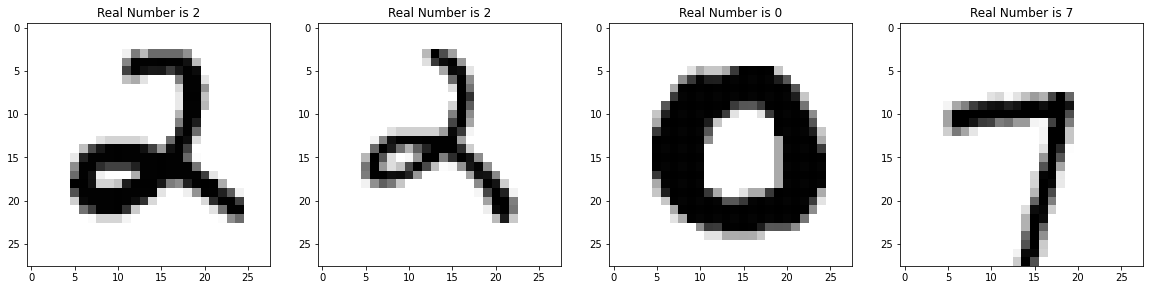

In [15]:
X_train_ = X_train.reshape(X_train.shape[0],28,28)

fig, axis = plt.subplots(1,4,figsize=(20,10))
for i,ax in enumerate(axis.flat):
    ax.imshow(X_train_[i],cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}")

**Normalization**

In [16]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

In [17]:
epochs = 50
batch_size = 64

**CNN**

In [18]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",input_shape=(28,28,1)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=128,kernel_size=(3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))

model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

**Data augmentation**

In [19]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size = batch_size)

For the data augmentation, i choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

**Model training**

In [20]:
# Fit the model
history = model.fit_generator(train_gen,epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
590/590 [==============================] - 320s 543ms/step - loss: 0.1537 - accuracy: 0.9515 - val_loss: 0.1124 - val_accuracy: 0.9656
Epoch 2/50
590/590 [==============================] - 311s 526ms/step - loss: 0.0729 - accuracy: 0.9783 - val_loss: 0.0839 - val_accuracy: 0.9750
Epoch 3/50
590/590 [==============================] - 324s 548ms/step - loss: 0.0511 - accuracy: 0.9848 - val_loss: 0.0536 - val_accuracy: 0.9827
Epoch 4/50
590/590 [==============================] - 292s 495ms/step - loss: 0.0475 - accuracy: 0.9845 - val_loss: 0.0533 - val_accuracy: 0.9849
Epoch 5/50
590/590 [==============================] - 293s 496ms/step - loss: 0.0443 - accuracy: 0.9869 - val_loss: 0.0484 - val_accuracy: 0.9839
Epoch 6/50
590/590 [==============================] - 278s 472ms/step - loss: 0.0407 - accuracy: 0.9877 - val_loss: 0.0576 - val_accuracy: 0.9829
Epoch 7/50
590/590 [============================

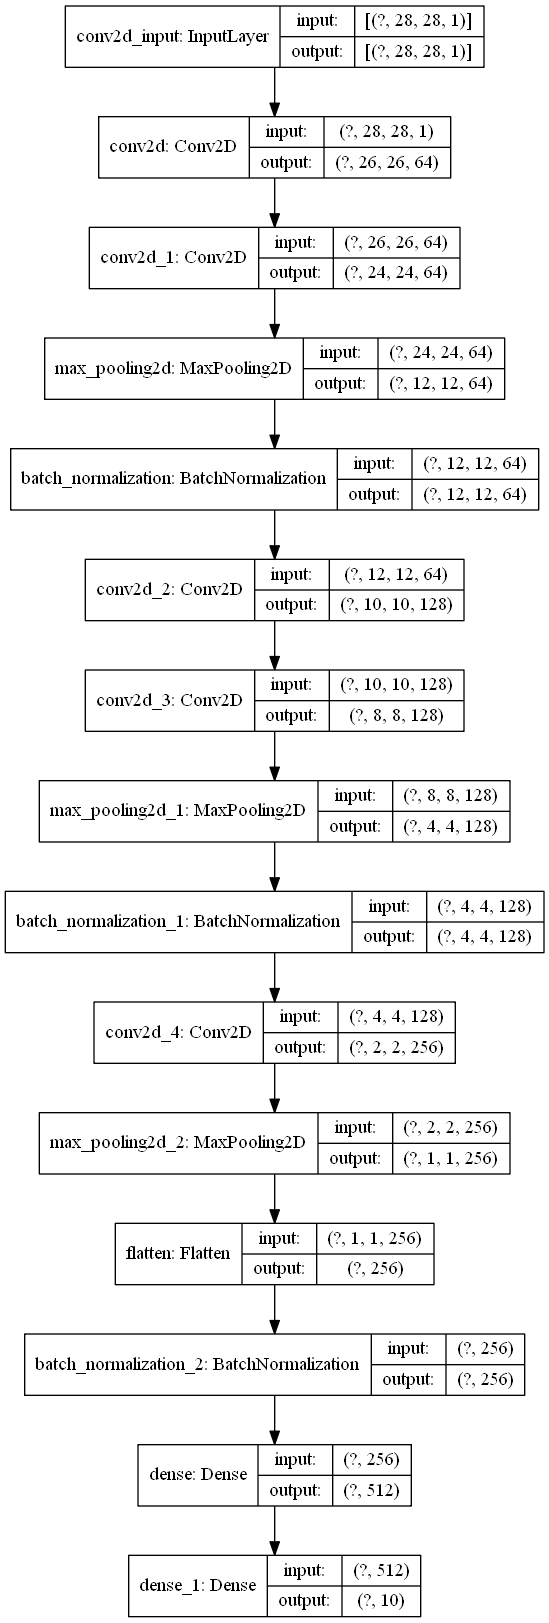

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Evaluate the model

**Training and validation curves**

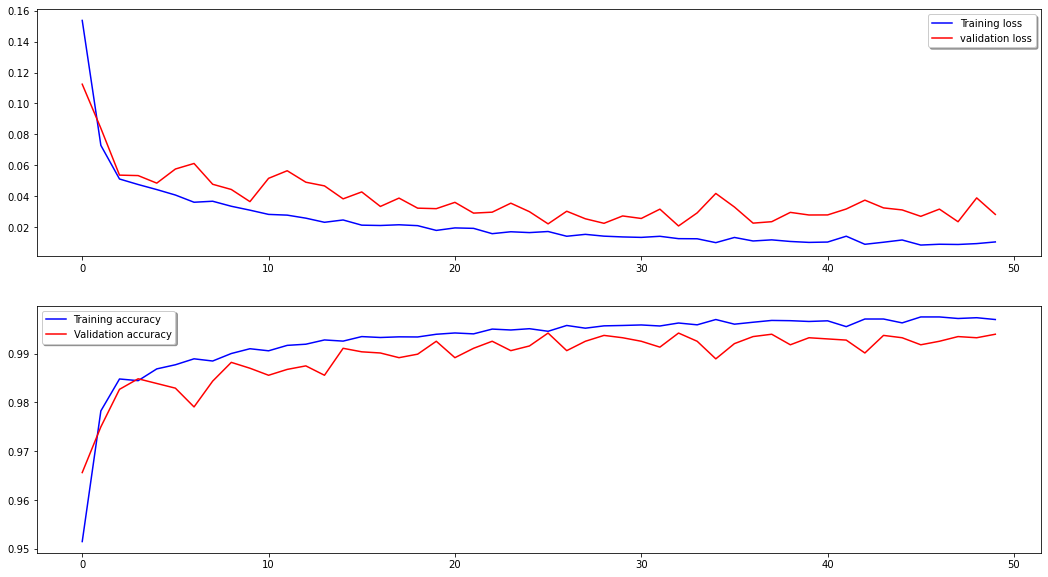

In [31]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18,10))
ax[0].plot(history.history['loss'],color = 'b',label = 'Training loss')
ax[0].plot(history.history['val_loss'],color = 'r',label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Confusion matrix**

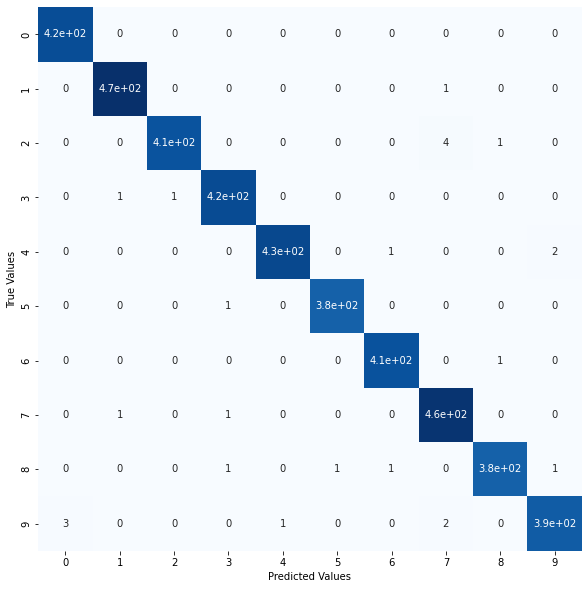

In [32]:
fig = plt.figure(figsize=(10,10))
y_pred = model.predict(X_test)

Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_test, 1)

mat = confusion_matrix(Y_test, Y_pred)

sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

**Prediction validation results**

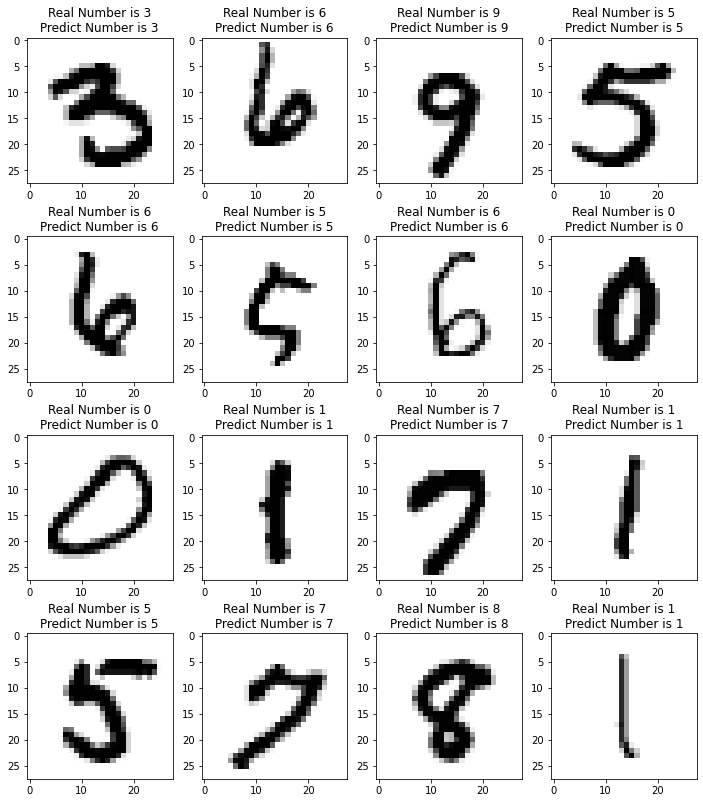

In [34]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");